In [2]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [3]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

In [23]:
player = "Andy-Murray"
print(np.where(W == player)[0])

[10]


# Gibbs sampling (This may take a minute)

In [5]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)


100%|██████████| 1100/1100 [01:39<00:00, 11.01it/s]


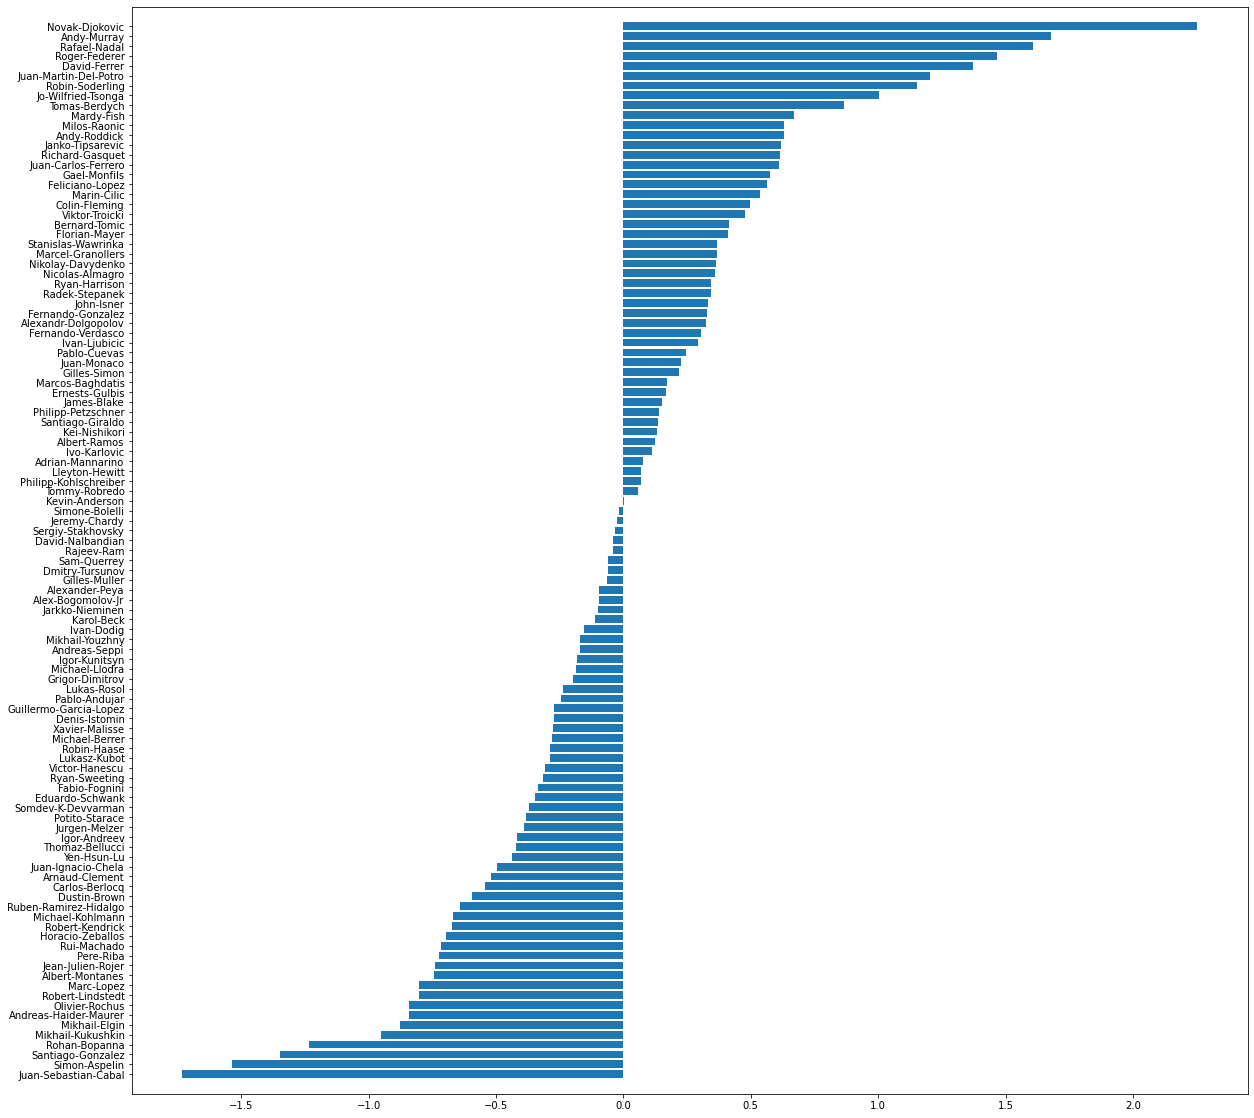

In [6]:
sorted_barplot(skill_samples[:,-1], W)

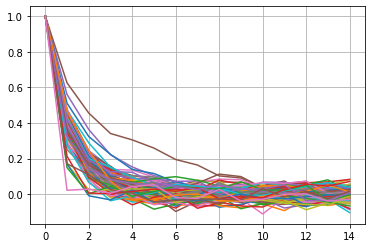

In [27]:
# Code for plotting the autocorrelation function for player p
n=15
p_arr = np.array(range(0, M))

for p in p_arr:
    autocor = np.zeros(n)
    for i in range(n):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
    plt.plot(autocor)
#plt.legend(W[p_arr][:,0])
plt.grid()

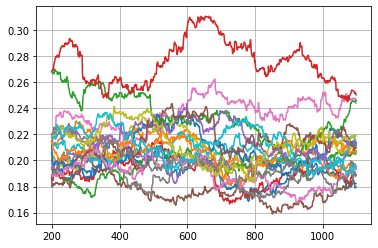

In [40]:
# Code for plotting the autocorrelation function for player p
window=200
num_players=20
p_arr = np.array(range(0, num_players))

for p in p_arr:
    rolling=pandas.DataFrame(skill_samples[p,:]).rolling(window=window)
    mean = rolling.mean()
    std = rolling.std()
    #plt.plot(mean)
    plt.plot(std)
#plt.legend(W[p_arr][:,0])
plt.grid()

['Novak-Djokovic']
['Rafael-Nadal']
['Michael-Llodra']
['Tomas-Berdych']


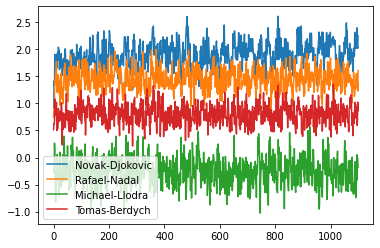

In [15]:
p_arr = [15, 0, 27, 33]
for p in p_arr:
    name = W[p]
    print(name)
    plt.plot(skill_samples[p,:])
plt.legend(W[p_arr][:,0])

# EP ranking

In [42]:
num_iters = 3
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)

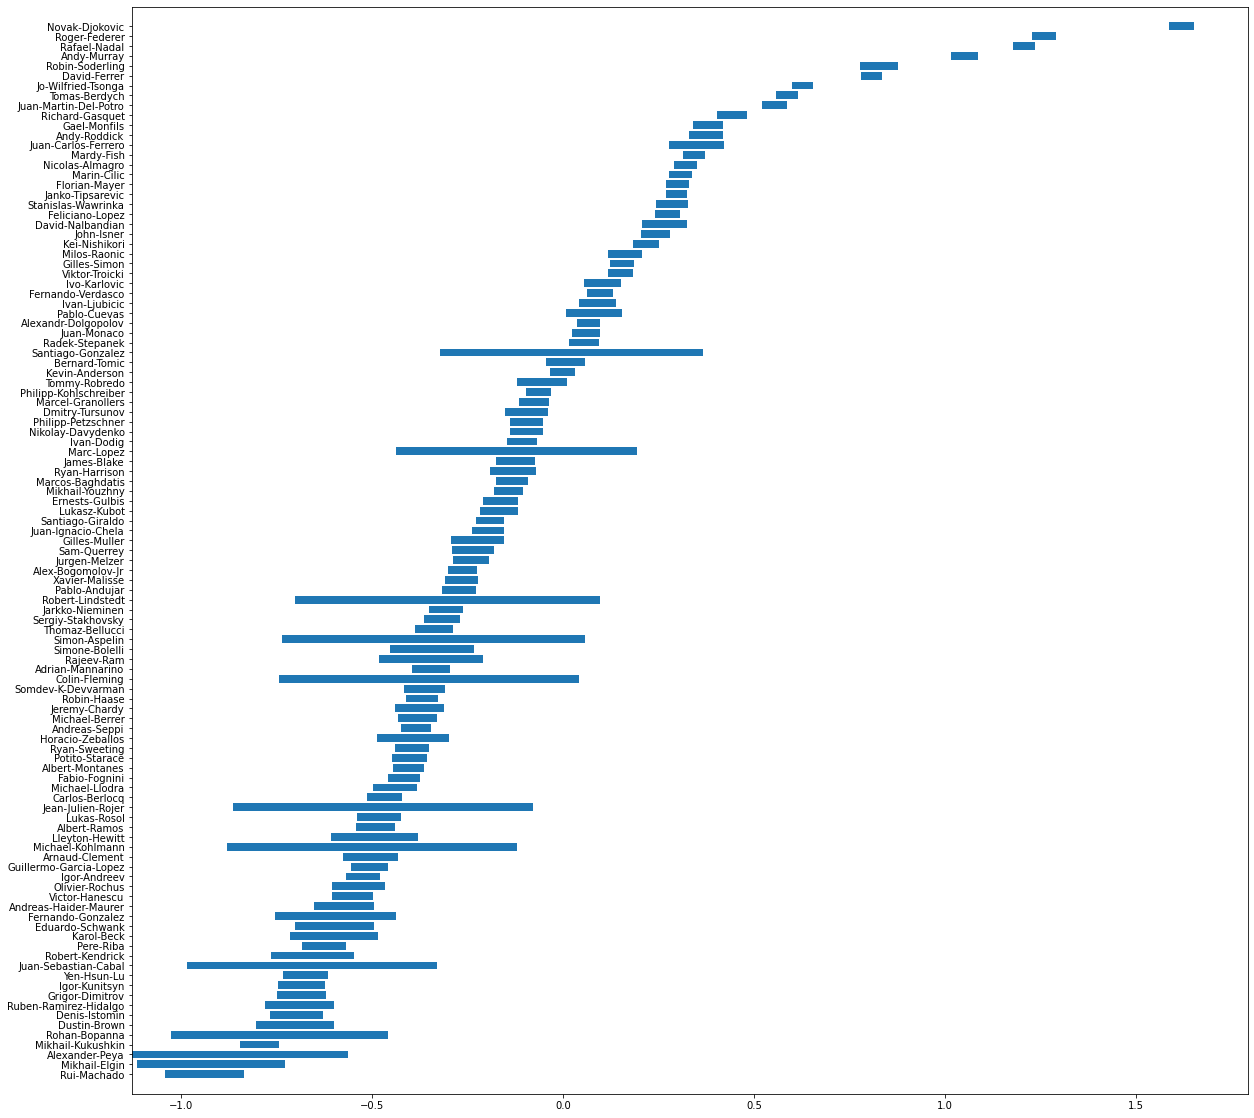

<Figure size 432x288 with 0 Axes>

In [60]:
def sorted_rangeplot(mean, std_dev, W):
    M = len(mean)
    xx = np.linspace(0, M, M)
    plt.figure(figsize=(20, 20))
    sorted_indices = np.argsort(mean)
    sorted_names = W[sorted_indices]
    width = 2 * std_dev
    left = mean - std_dev
    plt.barh(xx, width=width[sorted_indices], left=left[sorted_indices])
    plt.yticks(np.linspace(0, M, M), labels=sorted_names[:, 0])
    plt.ylim([-2, 109])
    plt.show()
    

std_dev = np.true_divide(1, precision_player_skills)
sorted_rangeplot(mean_player_skills, std_dev, W)

# Method comparison
1. Empirical game outcome averages
2. Gibbs sampling predictions
3. Message passing predictions

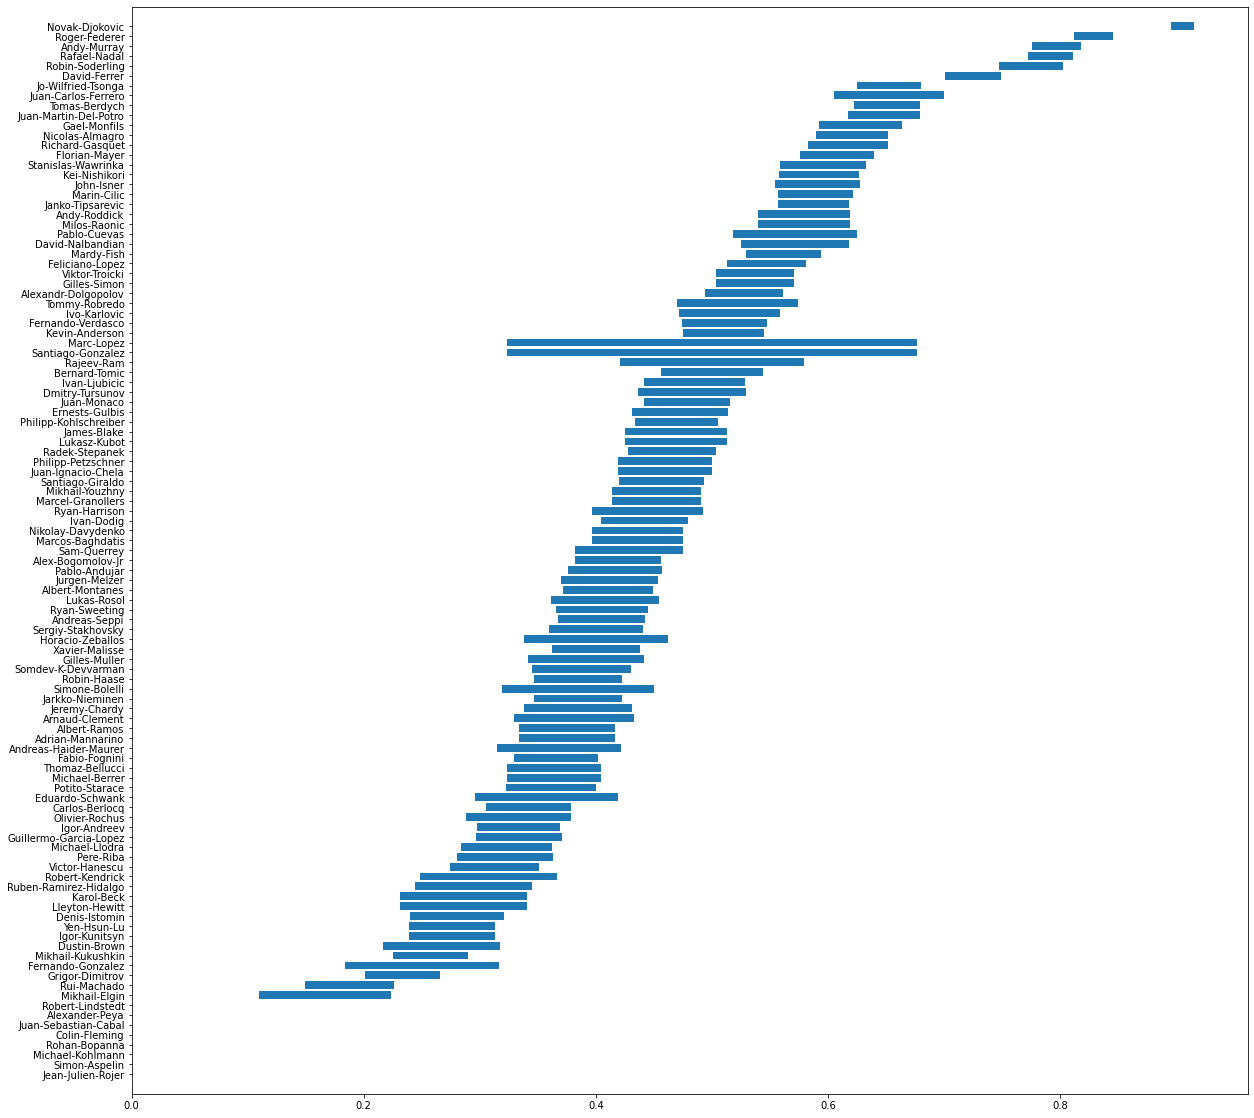

<Figure size 432x288 with 0 Axes>

In [58]:
points = np.zeros(M)
matches = np.zeros(M)

for p in range(0, M):
    for g in range(0, N):
        if G[g, 0] == p:
            points[p] += 1
            matches[p] += 1
        elif G[g, 1] == p:
            matches[p] += 1

win_ratio = np.true_divide(points, matches)
var = np.multiply(win_ratio, 1 - win_ratio)
std_dev = np.true_divide(var, np.sqrt(matches))
sorted_rangeplot(win_ratio, std_dev, W)